In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify the file path
file_path = 'physicians-in-canada-1971-2022.xlsx'

# Specify the range of columns to read (I was getting NaN where there was no real blanks) 
columns_range = 'A:BH'

# Specify the number of rows to read 
num_rows = 101698

# Read the specific range from the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='Table 1 Physician workforce', usecols=columns_range, nrows=num_rows)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101697 entries, 0 to 101696
Data columns (total 60 columns):
 #   Column                                                         Non-Null Count   Dtype  
---  ------                                                         --------------   -----  
 0   Year                                                           101697 non-null  int64  
 1   Jurisdiction                                                   101697 non-null  object 
 2   Health region                                                  86307 non-null   object 
 3   Specialty                                                      101697 non-null  object 
 4   Specialty sort                                                 101697 non-null  int64  
 5   Physician-to–100,000 population ratio                          100173 non-null  float64
 6   Number of physicians                                           101697 non-null  int64  
 7   Number male                                    

In [3]:
# dataset 1: Filter the dataframe for the 'Family Medicine' specialty & Atlantic provinces
family_medicine_df_atl = df[
    (df['Specialty sort'] == 3) & 
    (df['Jurisdiction'] == 'Alta.') & 
    ((pd.isna(df['Health region'])) | (df['Health region'] == 'Alta.'))
]

family_medicine_df_atl.info()

# dataset 2: Filter the dataframe for the 'Family Medicine' specialty in NB Jurisdiction
family_medicine_df_nb = df[
    (df['Specialty sort'] == 3) & 
    (df['Jurisdiction'] == 'N.B.') & 
    ((pd.isna(df['Health region'])) | (df['Health region'] == 'N.B.'))
]
family_medicine_df_nb.info()



<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 293 to 100555
Data columns (total 60 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Year                                                           52 non-null     int64  
 1   Jurisdiction                                                   52 non-null     object 
 2   Health region                                                  22 non-null     object 
 3   Specialty                                                      52 non-null     object 
 4   Specialty sort                                                 52 non-null     int64  
 5   Physician-to–100,000 population ratio                          52 non-null     float64
 6   Number of physicians                                           52 non-null     int64  
 7   Number male                                                    

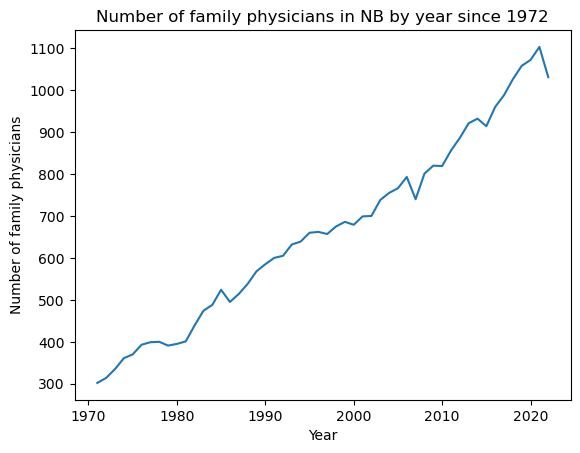

In [4]:
# Plot the time series using 'Year' as the x-axis
plt.plot(family_medicine_df_nb['Year'], family_medicine_df_nb['Number of physicians'])
plt.title('Number of family physicians in NB by year since 1972')
plt.xlabel('Year')
plt.ylabel('Number of family physicians')
plt.show()

# Testing for Stationarity

- Before we apply ARIMA, we need to ensure that the series is stationary, which involves checking if its statistical properties such as mean, variance, and autocorrelation are constant over time.

Initial Check with ADF (Augmented Dickey-Fuller) Test to look for stationarity.

In [5]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(family_medicine_df_nb['Number of physicians'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.023263
p-value: 0.960414


The results of the first ADF test has a high p-value (0.960414), indicating that the original 'Number of physicians' series in family_medicine_df_nb is non-stationary.

To make the dataset stationary it is possible to use the differencing technique to remove the trend or seasonality from the time series data for model fitting. 


In [6]:
# Compute first differences
diff_series = family_medicine_df_nb['Number of physicians'].diff().dropna()

# Perform ADF test on the differenced series
adf_test_diff = adfuller(diff_series)
# Output the results
print('ADF Statistic (after differencing): %f' % adf_test_diff[0])
print('p-value: %f' % adf_test_diff[1])


ADF Statistic (after differencing): -7.763177
p-value: 0.000000


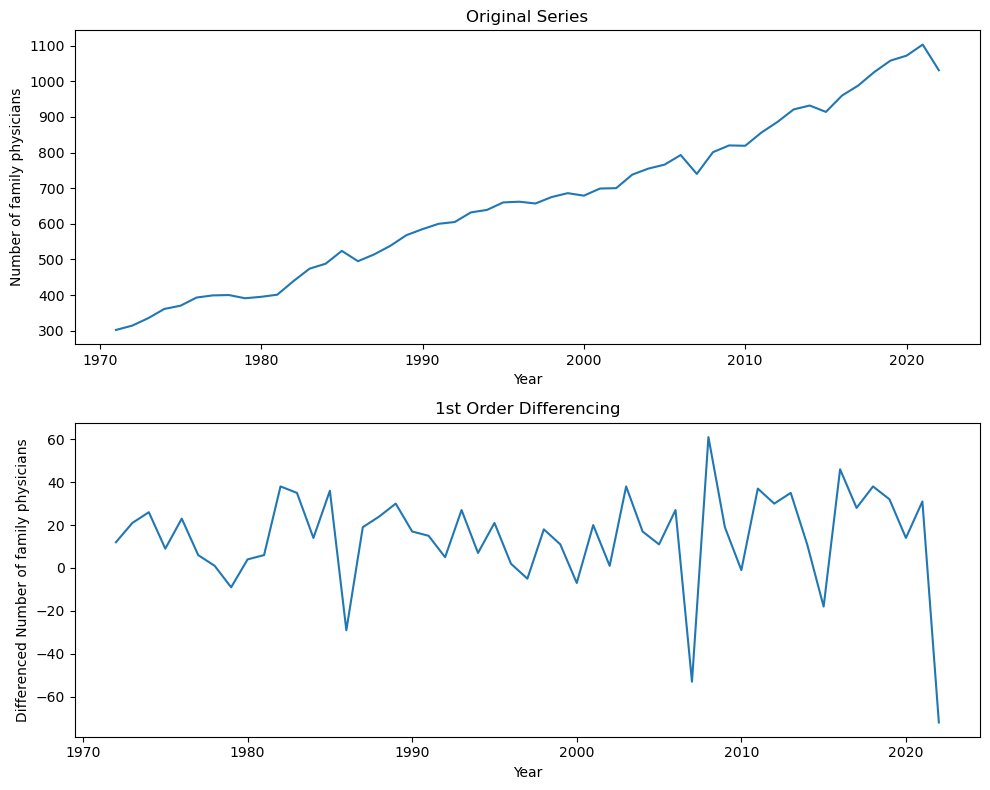

In [7]:
import matplotlib.pyplot as plt

# Original Series
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

# Plotting original series
ax1.plot(family_medicine_df_nb['Year'], family_medicine_df_nb['Number of physicians'])
ax1.set_title('Original Series')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of family physicians')

# 1st Differencing
diff_series = family_medicine_df_nb['Number of physicians'].diff().dropna()
ax2.plot(family_medicine_df_nb['Year'].iloc[1:], diff_series)  # Use iloc to align with diff_series
ax2.set_title('1st Order Differencing')
ax2.set_xlabel('Year')
ax2.set_ylabel('Differenced Number of family physicians')

plt.tight_layout()
plt.show()



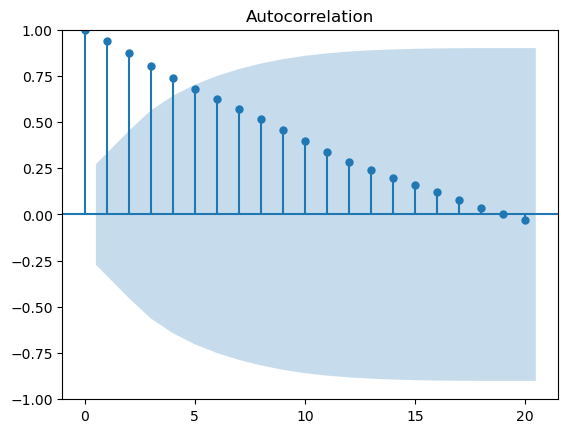

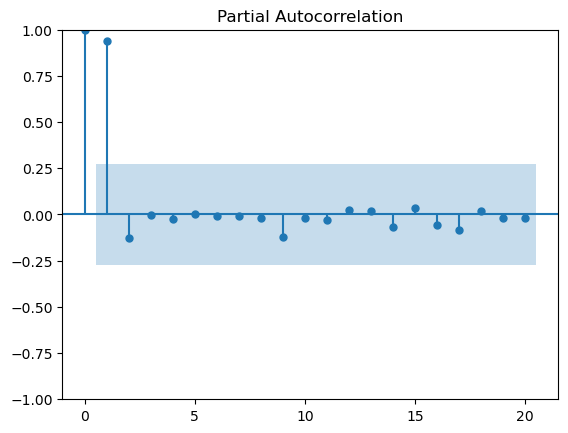

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ACF plot
sm.graphics.tsa.plot_acf(family_medicine_df_nb['Number of physicians'], lags=20)
plt.show()

# PACF plot
sm.graphics.tsa.plot_pacf(family_medicine_df_nb['Number of physicians'], lags=20)
plt.show()


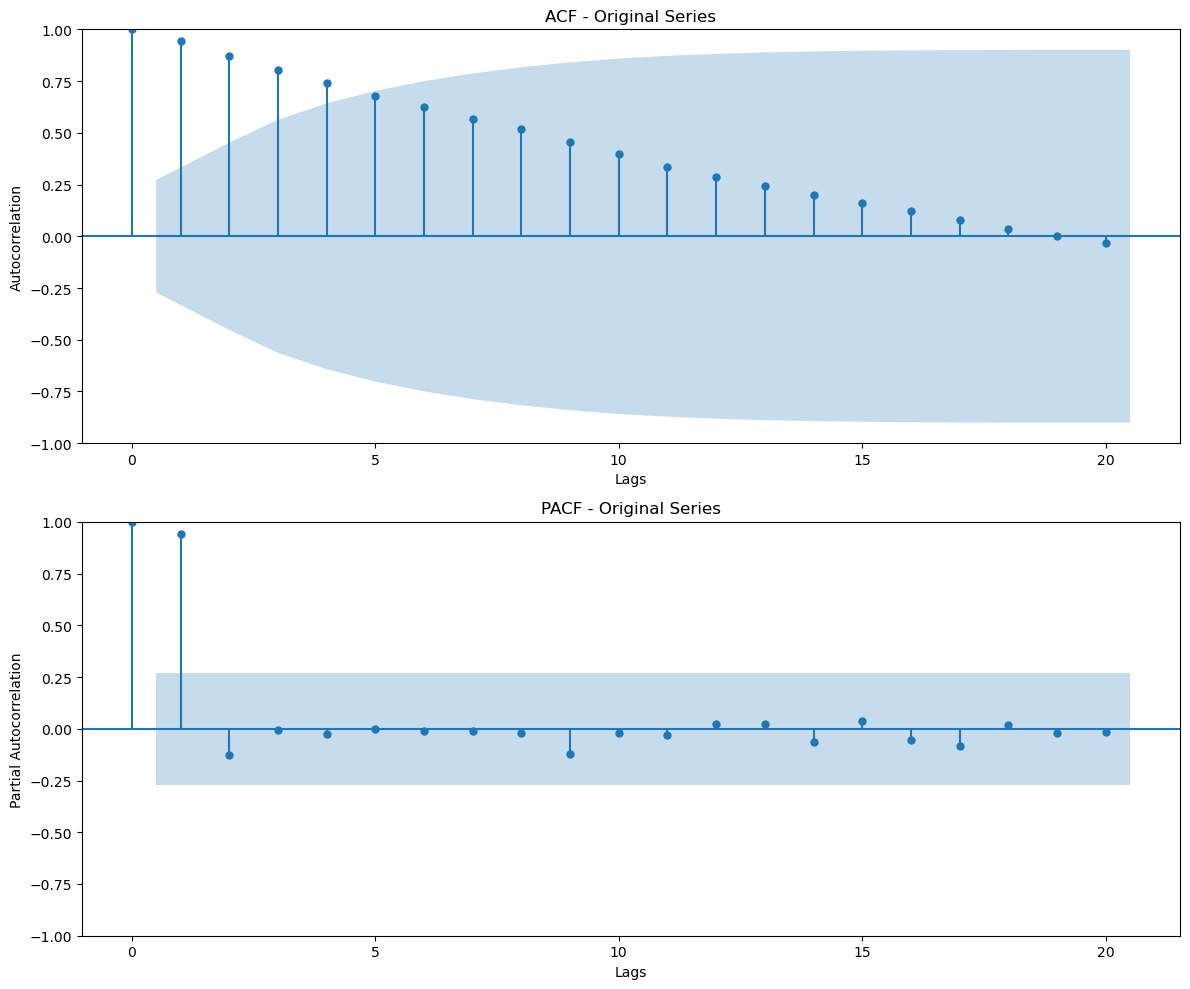

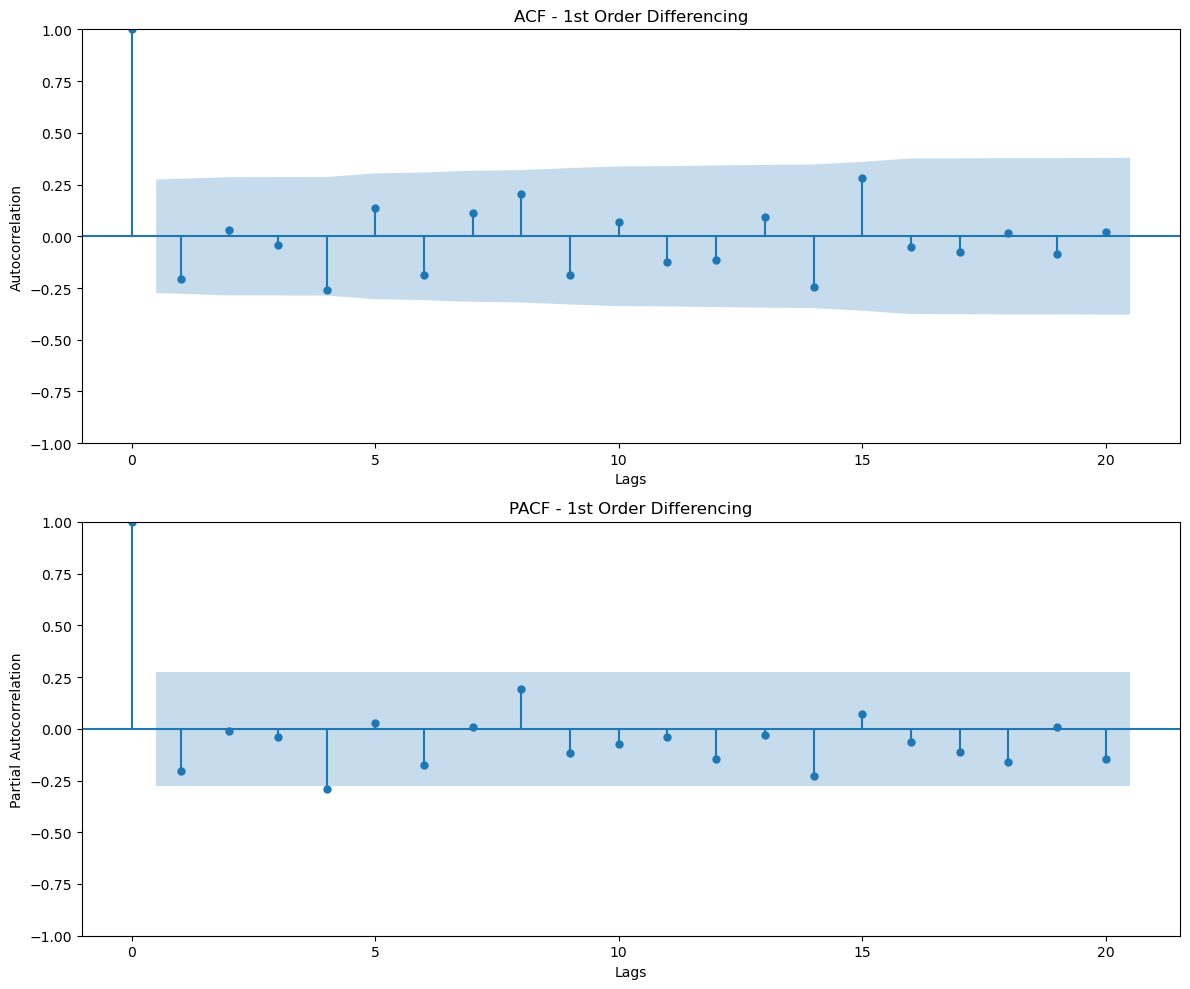

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Original Series
fig, (ax1_orig, ax2_orig) = plt.subplots(2, figsize=(12, 10))

# Plotting original series
sm.graphics.tsa.plot_acf(family_medicine_df_nb['Number of physicians'], lags=20, ax=ax1_orig)
ax1_orig.set_title('ACF - Original Series')
ax1_orig.set_xlabel('Lags')
ax1_orig.set_ylabel('Autocorrelation')

sm.graphics.tsa.plot_pacf(family_medicine_df_nb['Number of physicians'], lags=20, ax=ax2_orig)
ax2_orig.set_title('PACF - Original Series')
ax2_orig.set_xlabel('Lags')
ax2_orig.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# 1st Differencing
diff_series = family_medicine_df_nb['Number of physicians'].diff().dropna()

fig, (ax1_diff, ax2_diff) = plt.subplots(2, figsize=(12, 10))

# Plotting 1st differenced series
sm.graphics.tsa.plot_acf(diff_series, lags=20, ax=ax1_diff)
ax1_diff.set_title('ACF - 1st Order Differencing')
ax1_diff.set_xlabel('Lags')
ax1_diff.set_ylabel('Autocorrelation')

sm.graphics.tsa.plot_pacf(diff_series, lags=20, ax=ax2_diff)
ax2_diff.set_title('PACF - 1st Order Differencing')
ax2_diff.set_xlabel('Lags')
ax2_diff.set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd

# Example: Iterating over possible values
p_values = range(0, 3)  # Example: 0 to 2
d_values = range(0, 2)  # Example: 0 to 1
q_values = range(0, 3)  # Example: 0 to 2

best_aic = np.inf
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(family_medicine_df_nb['Number of physicians'], order=(p, d, q))
                model_fit = model.fit()
                current_aic = model_fit.aic
                if current_aic < best_aic:
                    best_aic = current_aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA Order (p, d, q): {best_order} with AIC: {best_aic}")


Best ARIMA Order (p, d, q): (2, 1, 1) with AIC: 472.7226980800434


In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model with results
model = ARIMA(diff_series, order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                                SARIMAX Results                                 
Dep. Variable:     Number of physicians   No. Observations:                   51
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -228.262
Date:                  Sun, 21 Jul 2024   AIC                            462.523
Time:                          11:40:40   BIC                            468.259
Sample:                               0   HQIC                           464.708
                                   - 51                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2608      0.176     -1.482      0.138      -0.606       0.084
ma.L1         -0.9992      4.106     -0.243      0.808      -9.046       7.048
sigma2       494.8085   2080.880    

In [12]:
# Fit ARIMA model with the best order
best_model = ARIMA(family_medicine_df_nb['Number of physicians'], order=best_order)
best_model_fit = best_model.fit()

# Print model summary for evaluation
print(best_model_fit.summary())


                                SARIMAX Results                                 
Dep. Variable:     Number of physicians   No. Observations:                   52
Model:                   ARIMA(2, 1, 1)   Log Likelihood                -232.361
Date:                  Sun, 21 Jul 2024   AIC                            472.723
Time:                          11:40:40   BIC                            480.450
Sample:                               0   HQIC                           475.676
                                   - 52                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7413      0.119      6.229      0.000       0.508       0.975
ar.L2          0.2587      0.119      2.176      0.030       0.026       0.492
ma.L1         -0.9989      0.146    

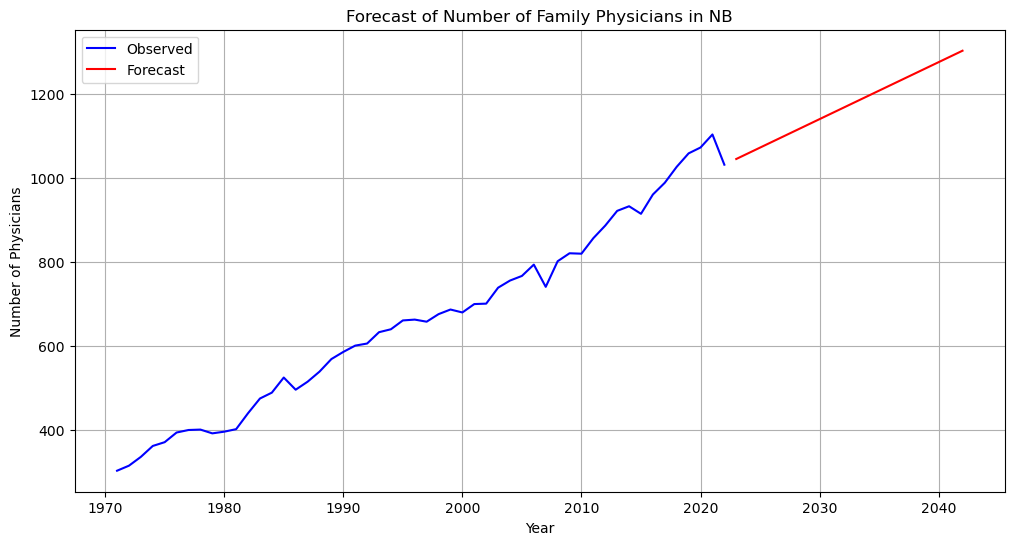

In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model (assuming ARIMA(1, 1, 1) based on your previous results)
model = ARIMA(family_medicine_df_nb['Number of physicians'], order=(1, 1, 1))
model_fit = model.fit()

# Forecasting future values 
forecast_steps = 20 #  Forecasting 10 steps into the future
forecast = model_fit.forecast(steps=forecast_steps)

# Plotting observed data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(family_medicine_df_nb['Year'], family_medicine_df_nb['Number of physicians'], label='Observed', color='blue')
plt.plot(range(family_medicine_df_nb['Year'].max() + 1, family_medicine_df_nb['Year'].max() + 1 + forecast_steps), forecast, label='Forecast', color='red')
plt.title('Forecast of Number of Family Physicians in NB')
plt.xlabel('Year')
plt.ylabel('Number of Physicians')
plt.legend()
plt.grid(True)
plt.show()


                                SARIMAX Results                                 
Dep. Variable:     Number of physicians   No. Observations:                   51
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -228.262
Date:                  Sun, 21 Jul 2024   AIC                            462.523
Time:                          11:40:40   BIC                            468.259
Sample:                               0   HQIC                           464.708
                                   - 51                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2608      0.176     -1.482      0.138      -0.606       0.084
ma.L1         -0.9992      4.106     -0.243      0.808      -9.046       7.048
sigma2       494.8085   2080.880    

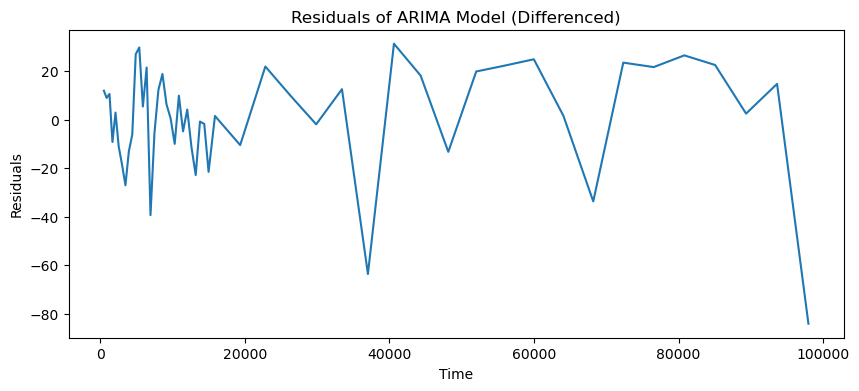

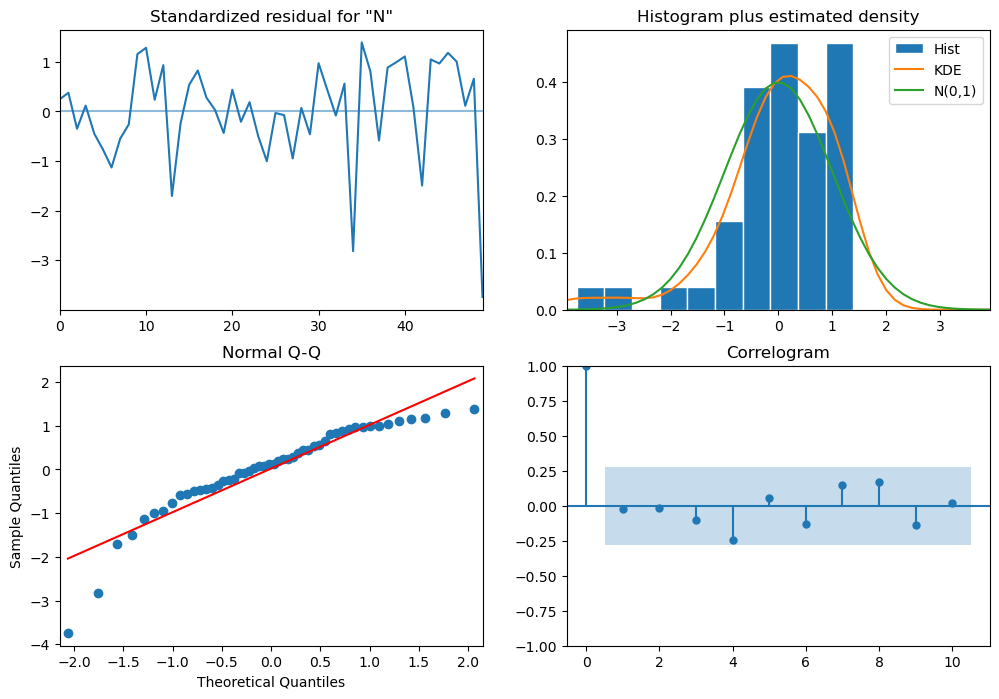

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

#  family_medicine_df_nb['Year'] is your index or time column

# Compute first differences
diff_series = family_medicine_df_nb['Number of physicians'].diff().dropna()

# Define the order (p, d, q)
p, d, q = 1, 1, 1  # Example order based on previous analysis

# Create the ARIMA model with differenced data
model = sm.tsa.ARIMA(diff_series, order=(p, d, q))

# Fit the model
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model (Differenced)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot diagnostic plots
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

## CHOOSING p,d,q values, (again, restarting ) 

When choosing the p,d,q parameters for an ARIMA model, you need to consider whether the series is stationary or non-stationary:
1. Non-Stationary Series:
	- If your time series data is non-stationary (e.g., it exhibits trends or seasonality), you typically need to difference the series to achieve stationarity before fitting an ARIMA model.
	- Use differencing (parameter d) to make the series stationary. The differenced series should have constant mean and variance over time.
	- Once stationary, you can then analyze ACF and PACF plots to identify potential values for p (autoregressive) and q (moving average).

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(family_medicine_df_nb['Number of physicians'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: 0.023263
p-value: 0.960414


In [16]:
# Compute first differences
diff_series = family_medicine_df_nb['Number of physicians'].diff().dropna()

# Perform ADF test on the differenced series
adf_test_diff = adfuller(diff_series)
# Output the results
print('ADF Statistic (after differencing): %f' % adf_test_diff[0])
print('p-value: %f' % adf_test_diff[1])

print("d value is equal to 1")

ADF Statistic (after differencing): -7.763177
p-value: 0.000000
d value is equal to 1


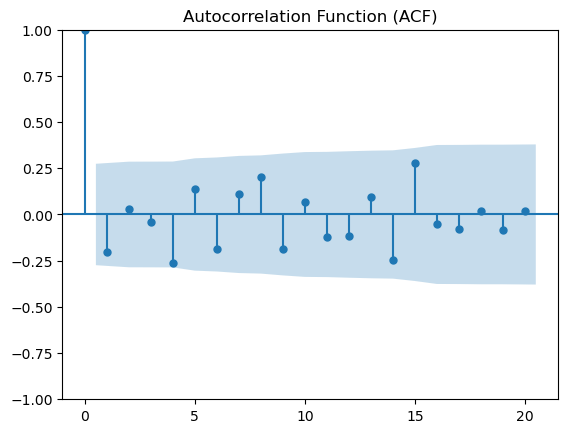

q value is equal to 1


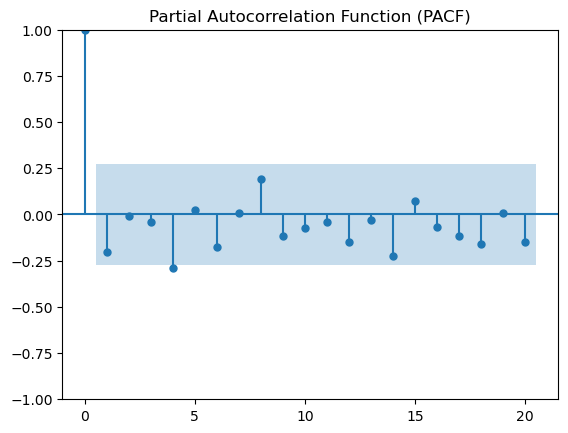

p value is equal to 1


In [17]:

# ACF plot to determine q value
sm.graphics.tsa.plot_acf(diff_series, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()
print("q value is equal to 1")

# PACF plot to determine p value
sm.graphics.tsa.plot_pacf(diff_series, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()
print("p value is equal to 1")



- The ACF plot shows significant autocorrelation at lag 1 (x-axis 0) but no significant autocorrelation at other lags, which indicates a spike that extends beyond the confidence interval only at lag 1.
- The PACF plot shows a significant spike at lag 1 (x-axis 0), indicating direct correlation with the previous observation but no significant correlations at other lags.



In [18]:
#Test the model fit
from statsmodels.tsa.arima.model import ARIMA

# Specify your values for p, d, q based on interpretation
p = 1
d = 1
q = 1

# Fit the ARIMA model
model = ARIMA(family_medicine_df_nb['Number of physicians'], order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                                SARIMAX Results                                 
Dep. Variable:     Number of physicians   No. Observations:                   52
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -233.587
Date:                  Sun, 21 Jul 2024   AIC                            473.173
Time:                          11:40:41   BIC                            478.969
Sample:                               0   HQIC                           475.388
                                   - 52                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2034.299      0.000       0.999       1.001
ma.L1         -0.9986      0.127     -7.861      0.000      -1.248      -0.750
sigma2       526.0802      0.000   2

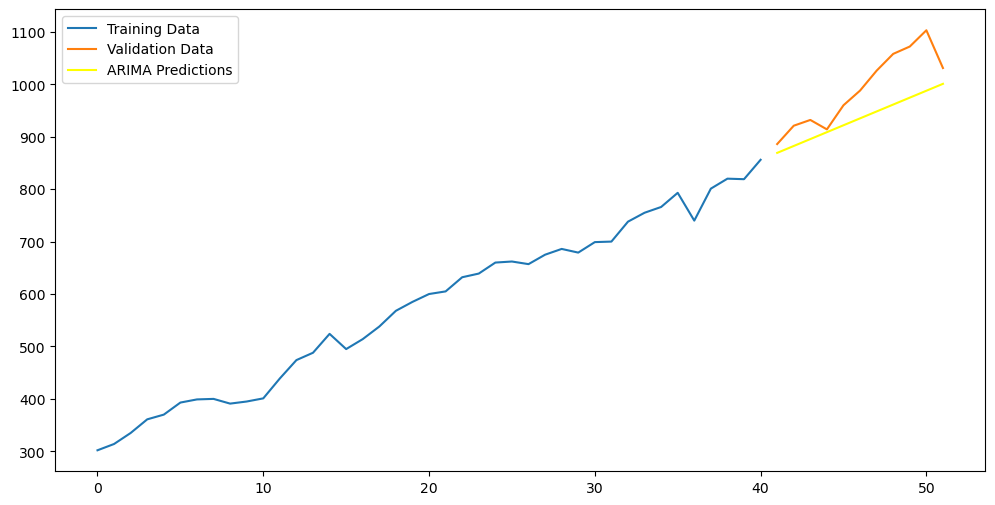

RMSE:  65.01411891897584


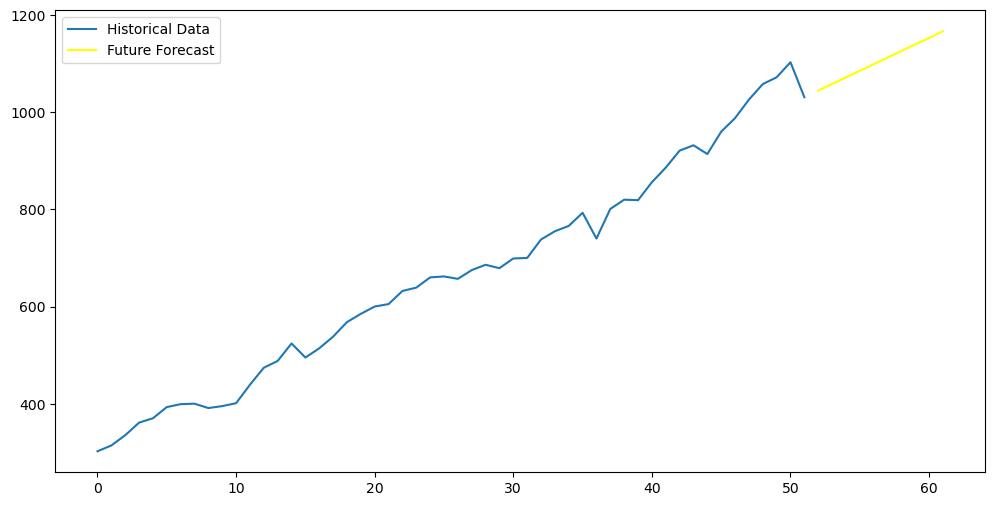

In [19]:
# Sort the dataframe by year and reset the index
family_medicine_df_nb = family_medicine_df_nb.sort_values('Year').reset_index(drop=True)

# Extract the 'Number of physicians' column
data = family_medicine_df_nb['Number of physicians']

# Split data into train and validation sets
train_size = int(len(data) * 0.8)
train, validation = data[:train_size], data[train_size:]

# Fit the ARIMA model
ARIMAmodel = ARIMA(train, order=(1, 1, 1))
ARIMAmodel = ARIMAmodel.fit()

# Make predictions on the validation set
y_pred = ARIMAmodel.get_forecast(steps=len(validation))
y_pred_df = y_pred.conf_int(alpha=0.05)
y_pred_df["Predictions"] = ARIMAmodel.predict(start=validation.index[0], end=validation.index[-1])
y_pred_df.index = validation.index
y_pred_out = y_pred_df["Predictions"]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(validation, label='Validation Data')
plt.plot(y_pred_out, color='yellow', label='ARIMA Predictions')
plt.legend()
plt.show()

# Calculate RMSE
arma_rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
print("RMSE: ", arma_rmse)

# fit it on the entire dataset
ARIMAmodel_full = ARIMA(data, order=(1, 1, 1))
ARIMAmodel_full = ARIMAmodel_full.fit()

# Forecast future values
forecast_steps = 10  # Number of future periods to forecast
future_forecast = ARIMAmodel_full.get_forecast(steps=forecast_steps)
future_forecast_df = future_forecast.conf_int(alpha=0.05)
future_forecast_df["Predictions"] = ARIMAmodel_full.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.plot(range(len(data), len(data) + forecast_steps), future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
plt.legend()
plt.show()

# Tuning Hyperparameters
- Using a grid search approach to find the best combination of ARIMA parameters (p, d, q).

ARIMA(0, 0, 0) RMSE=418.5866473822011
ARIMA(0, 0, 1) RMSE=411.02414157451085
ARIMA(0, 0, 2) RMSE=401.96683958361064
ARIMA(0, 1, 0) RMSE=150.90605144803294
ARIMA(0, 1, 1) RMSE=148.70074710593383
ARIMA(0, 1, 2) RMSE=164.34234230351169
ARIMA(0, 2, 0) RMSE=105.96526017350598
ARIMA(0, 2, 1) RMSE=60.83280452251429
ARIMA(0, 2, 2) RMSE=68.25384715986256
ARIMA(1, 0, 0) RMSE=158.3180055404624
ARIMA(1, 0, 1) RMSE=157.0581984611855
ARIMA(1, 0, 2) RMSE=180.8555734736873
ARIMA(1, 1, 0) RMSE=146.87128750057596
ARIMA(1, 1, 1) RMSE=65.01411891897584
ARIMA(1, 1, 2) RMSE=163.39170793306144
ARIMA(1, 2, 0) RMSE=27.919699027828877
ARIMA(1, 2, 1) RMSE=66.4029024046678
ARIMA(1, 2, 2) RMSE=70.3816806535317
ARIMA(2, 0, 0) RMSE=156.07154469830326
ARIMA(2, 0, 1) RMSE=158.0963276995034
ARIMA(2, 0, 2) RMSE=180.9027397885611
ARIMA(2, 1, 0) RMSE=129.86895342407857
ARIMA(2, 1, 1) RMSE=68.72812518451289
ARIMA(2, 1, 2) RMSE=70.74741014472218
ARIMA(2, 2, 0) RMSE=38.42435406527627
ARIMA(2, 2, 1) RMSE=62.89710100610015
ARI

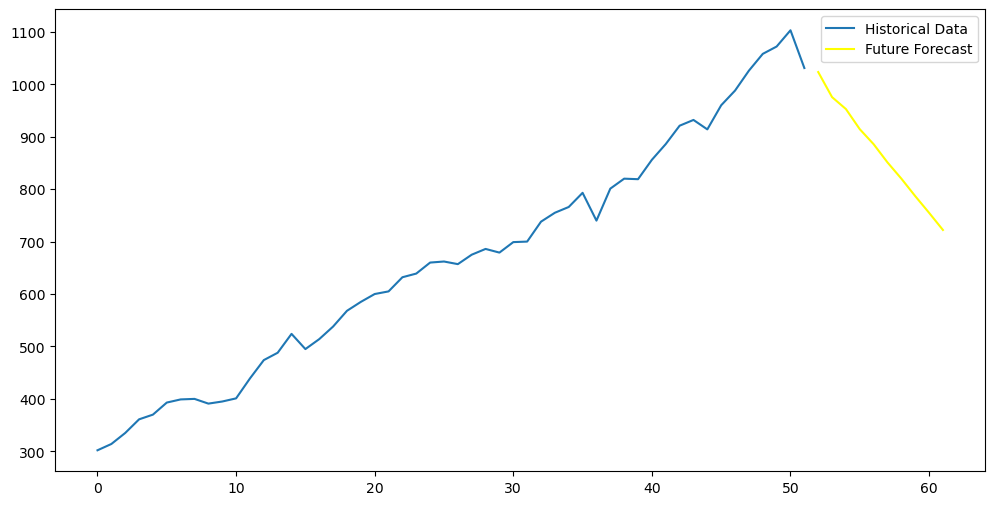

In [20]:
# Define a function to evaluate ARIMA model
def evaluate_arima_model(train, validation, arima_order):
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(steps=len(validation))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df["Predictions"] = model_fit.predict(start=validation.index[0], end=validation.index[-1])
    y_pred_df.index = validation.index
    y_pred_out = y_pred_df["Predictions"]
    rmse = np.sqrt(mean_squared_error(validation.values, y_pred_out))
    return rmse

# Grid search for ARIMA hyperparameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
best_score, best_cfg = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                rmse = evaluate_arima_model(train, validation, order)
                if rmse < best_score: best_score, best_cfg = rmse, order
                print(f'ARIMA{order} RMSE={rmse}')
            except:
                continue

print(f'Best ARIMA{best_cfg} RMSE={best_score}')

# Fit the best model on the entire dataset and forecast future values
best_model = ARIMA(data, order=best_cfg)
best_model_fit = best_model.fit()

# Forecast future values
forecast_steps = 10
future_forecast = best_model_fit.get_forecast(steps=forecast_steps)
future_forecast_df = future_forecast.conf_int(alpha=0.05)
future_forecast_df["Predictions"] = best_model_fit.predict(start=len(data), end=len(data) + forecast_steps - 1)

# Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')
plt.plot(range(len(data), len(data) + forecast_steps), future_forecast_df["Predictions"], color='yellow', label='Future Forecast')
plt.legend()
plt.show()